# Analyze offline payment method



#### Описание проекта
Часть 1. Общий анализ

    1.1 Какую долю Offline GMV составляет от всего GMV за год (2021).
    1.2. Как эта доля ведет себя, если смотреть помесячно
    2.1  То же самое, но отдельно по Direct  и Partners 
    3. Как все указанные выше параметры за 2021 соотносятся с 2020

#### Часть 2. Дополнительные вопросы 

    1.Как использование offline pm зависит от вертикали.

    2.Как использование offline pm зависит от тарифного плана. 

    3.Как использование offline pm зависит от страны. В каких странах больше всего используется offline pm (в абсолютном и относительном выражении).

    4.Если магазин cash only , то  узнать, были ли у них ранее подключены онлайн платежи? Возможно, продавцы раньше принимали оплату онлайн, но им что-то не понравилось и они отказались от онлайн оплаты полностью. Нужны списки таких клиентов.

    5.Как наличие offline pm коррелирует в методами доставки? Какие способы получения заказа доступны? 

   

In [1]:
# Импортируем библиотеки
import pandas as pd
import numpy as np
from IPython.display import display
import plotly.express as px 
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
from pandas.plotting import scatter_matrix
import math
#import random
import sys
import warnings
if not sys.warnoptions:
       warnings.simplefilter("ignore")


import requests
import re
from datetime import datetime

In [2]:
# Вывод всех строк таблицы на экран
from IPython.display import display
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_colwidth', None)
pd.options.display.max_rows = 50

# 1.Общая загрузка файлов

In [ ]:
## Заливка  отчета по GMV за 2020-2021 год была из облака 
gmv_main_raw = pd.read_csv(input_file, sep='\t')
gmv_main_raw.head()

In [ ]:
## Заливка отчета по GMV за январь 2022
gmv_raw_jan2022 = pd.read_csv(input_file)
gmv_raw_jan2022.head()

In [ ]:
## Заливка отчета по активным магазинам в январе 2022
pos_raw_jan2022 = pd.read_csv(input_file_2)
pos_raw_jan2022.head()

# 2.Предобработка данных


## Предобработка отчета по GMV за 2020-2021 год

In [7]:
# Заменим пробелы в названиях столбцов на _
gmv_main_raw.columns = gmv_main_raw.columns.str.replace(' ', '_')

In [8]:
gmv_main_raw.info(verbose=True, null_counts=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  """Entry point for launching an IPython kernel.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2943804 entries, 0 to 2943803
Data columns (total 36 columns):
 #   Column                         Non-Null Count    Dtype  
---  ------                         --------------    -----  
 0   period                         2943804 non-null  object 
 1   store_id                       2943804 non-null  int64  
 2   hashed_store_id                2943804 non-null  object 
 3   channel_type                   2943804 non-null  object 
 4   channel_id                     2943804 non-null  object 
 5   plan_title                     2943804 non-null  object 
 6   plan_id                        2943804 non-null  object 
 7   renewal_period                 2943804 non-null  object 
 8   office_country                 2941828 non-null  object 
 9   office_state_/_province_code   2943804 non-null  object 
 10  office_geo_region              2943804 non-null  object 
 11  office_economic_region         1633076 non-null  object 
 12  billing_countr

In [9]:
# Заменим название
gmv_main_raw = gmv_main_raw.rename(columns={'$_gmv': 'gmv', \
                                            'office_country': 'country', \
                                            '#_of_orders': 'n_orders'})

In [10]:
# Копирую нужные столбцы
gmv_main = gmv_main_raw[['period', \
               'store_id', \
               'payment_method', \
               'channel_type', \
               'gmv', \
               'vertical', \
               'plan_title', \
               'country', \
              'carrier', \
              'carrier_method', \
               'signup_period' , \
              'n_orders']].copy()

In [11]:
gmv_main['carrier'] = gmv_main['carrier'].fillna('UNKNOWN')

gmv_main['carrier'].value_counts(normalize=True)

UNKNOWN           0.70
<Pickup>          0.12
U.S.P.S.          0.08
USPS              0.02
UPS               0.02
                  ... 
Surepost Ground   0.00
Colissimo         0.00
quiken            0.00
APC               0.00
WRCJED014         0.00
Name: carrier, Length: 275, dtype: float64

In [12]:
gmv_main['carrier_method'] = gmv_main['carrier_method'].fillna('UNKNOWN')

In [ ]:
gmv_main['carrier_method'].value_counts()

In [14]:
# Замена вертикали - на категорию UNSPECIFIED
gmv_main['vertical'] = gmv_main['vertical'].str.replace('-', 'UNSPECIFIED')

In [ ]:
# Проверка
gmv_main['vertical'].value_counts()

In [16]:
# смотрим % соотношение
gmv_main['vertical'].value_counts(normalize=True)

UNSPECIFIED             0.61
apparel                 0.07
other                   0.05
health                  0.05
food_ecommerce          0.04
toys                    0.02
food_restaurant         0.02
books                   0.02
gifts                   0.02
services                0.01
sports                  0.01
art                     0.01
jewelry                 0.01
electronics             0.01
hardware                0.01
home                    0.01
pet                     0.01
auto                    0.01
notsure                 0.01
food                    0.00
tobacco                 0.00
office                  0.00
adult                   0.00
streaming               0.00
subscription_products   0.00
What are you selling    0.00
Name: vertical, dtype: float64

In [ ]:
gmv_main['country'].value_counts().head(10)

In [ ]:
# Смотрим % соотношение
gmv_main['country'].value_counts(normalize=True).head(10)

In [19]:
# Перевод period в формат даты
gmv_main['period_new'] = pd.to_datetime(gmv_main['period'])

In [20]:
gmv_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2943804 entries, 0 to 2943803
Data columns (total 13 columns):
 #   Column          Dtype         
---  ------          -----         
 0   period          object        
 1   store_id        int64         
 2   payment_method  object        
 3   channel_type    object        
 4   gmv             float64       
 5   vertical        object        
 6   plan_title      object        
 7   country         object        
 8   carrier         object        
 9   carrier_method  object        
 10  signup_period   object        
 11  n_orders        int64         
 12  period_new      datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2), object(9)
memory usage: 292.0+ MB


In [21]:
# Создаю новый столбец с годом
gmv_main['year'] = gmv_main['period_new'].dt.year

In [ ]:
gmv_main['year'].value_counts()

In [23]:
# Функция по добавлению нового столбца
def new_column(df, new_col, col, new_list):
    df[new_col] = df[col] 
    df.loc[~df[col].isin(new_list), new_col] = 'other'
    print(df[new_col].value_counts())


In [24]:
new_pm_list = ['OFF LINE']
new_column(gmv_main, 'new_pm', 'payment_method', new_pm_list)

other       2254523
OFF LINE     689281
Name: new_pm, dtype: int64


In [ ]:
new_plan_list = ['Business', 'Free', 'Unlimited', 'Venture']
new_column(gmv_main, 'new_plan', 'plan_title', new_plan_list)

In [ ]:
# Создаю новый столбец по каналам согласно ТЗ
gmv_main['new_channel'] = 0
gmv_main.loc[gmv_main['channel_type'] == "Direct", 'new_channel'] = 'Direct'
gmv_main.loc[gmv_main['channel_type'] == "Affiliates", 'new_channel'] = 'Direct'
gmv_main.loc[gmv_main['channel_type'] == "Resellers", 'new_channel'] = 'Partner'
gmv_main.loc[gmv_main['channel_type'] == "JumpStart partners", 'new_channel'] = 'Partner'
gmv_main.head()

## Предобработка отчета по GMV за январь 2022

In [1]:
gmv_raw_jan2022.info()

In [28]:
# Заменим пробелы в названиях столбцов на _
gmv_raw_jan2022.columns = gmv_raw_jan2022.columns.str.replace(' ', '_')

# Заменим название
gmv_raw_jan2022 = gmv_raw_jan2022.rename(columns={'$_gmv': 'gmv', \
                                                  'office_country': 'country', \
                                                  '#_of_orders': 'n_orders'})

# Копирую нужные столбцы
gmv_jan2022 = gmv_raw_jan2022[['store_id', \
               'payment_method', \
               'gmv', \
               'carrier', \
              'country', \
              'carrier_method', \
              'n_orders']].copy()

In [2]:
gmv_jan2022.info()

In [30]:
gmv_jan2022['carrier'] = gmv_jan2022['carrier'].fillna('UNKNOWN')
gmv_jan2022['carrier_method'] = gmv_jan2022['carrier_method'].fillna('UNKNOWN')

In [3]:
new_pm_list2 = ['OFF LINE']
new_column(gmv_jan2022, 'new_pm', 'payment_method', new_pm_list2)


In [33]:
# Беру нужные столбцы из gmv_jan2022
gmv_jan2022_1 = gmv_jan2022[['store_id', 'carrier', 'carrier_method', 'new_pm', 'gmv', 'country']].copy()

## Предобработка отчета по активным магазинам за январь 2022

In [4]:
pos_raw_jan2022.info()

In [ ]:
# переименовываю столбцы
pos_raw_jan2022 = pos_raw_jan2022.rename(columns={'use__pos_clover': 'clover', \
                                 'use__pos_vend' : 'vend', \
                                 'use__pos_square': 'square', \
                                 'installed__pos_shopkeep': 'shopkeep', \
                               'use__pos_lightspeed' : 'LSPD'})
pos_raw_jan2022.head()

In [36]:
# Замена Nan на 0
pos_raw_jan2022['clover'] = pos_raw_jan2022['clover'].fillna('NO')
pos_raw_jan2022['vend'] = pos_raw_jan2022['vend'].fillna('NO')
pos_raw_jan2022['square'] = pos_raw_jan2022['square'].fillna('NO')
pos_raw_jan2022['shopkeep'] = pos_raw_jan2022['shopkeep'].fillna('NO')
pos_raw_jan2022['LSPD'] = pos_raw_jan2022['LSPD'].fillna('NO')

In [ ]:
# Копирую нужные столбцы в новую таблицу
pos_jan2022 = pos_raw_jan2022[['store_id', 'clover', 'square', 'vend', 'LSPD', 'shopkeep', 'ftu_period']].copy()

# Перевод ftu_date в формат даты
pos_jan2022['ftu_new'] = pd.to_datetime(pos_jan2022['ftu_period'])
pos_jan2022['ftu_year'] = pos_jan2022['ftu_new'].dt.year
pos_jan2022.head()

# 3.Общий анализ

## 3.1.Доля Offline GMV  от всего GMV за год (2020-2021)

In [5]:
# Сводная по годам общая
gmv_main_years = gmv_main.pivot_table(
index='year', columns = 'new_pm', values ='gmv', aggfunc = 'sum').reset_index()

gmv_main_years.columns = ['year', 'off_line_gmv', 'other_gmv']

gmv_main_years['%'] = gmv_main_years['off_line_gmv'] / (gmv_main_years['off_line_gmv'] + gmv_main_years['other_gmv'])*100

gmv_main_years

## 3.2. Доля Offline GMV от всего GMV помесячно за период 2020-2021

In [ ]:
# Сводная помесячно
gmv_main_months = gmv_main.pivot_table(
index=['period_new'], columns = 'new_pm', values ='gmv', aggfunc = 'sum').reset_index().fillna(0)

gmv_main_months.columns = ['period_new', 'off_line_gmv', 'other_gmv']

gmv_main_months['%'] = gmv_main_months['off_line_gmv'] / (gmv_main_months['off_line_gmv'] + gmv_main_months['other_gmv'])*100
gmv_main_months['month'] = gmv_main_months['period_new'].dt.month
gmv_main_months['year'] = gmv_main_months['period_new'].dt.year 


gmv_main_months.head()

## 3.3.Соотношение долей GMV 2020-2021

In [ ]:
# gmv_main_months2020 по 2020 году
gmv_main_months2020 = gmv_main_months.query('period_new <= "2020-12-31"').rename(columns={'%' : '%_2020'}).fillna(0)
gmv_main_months2020

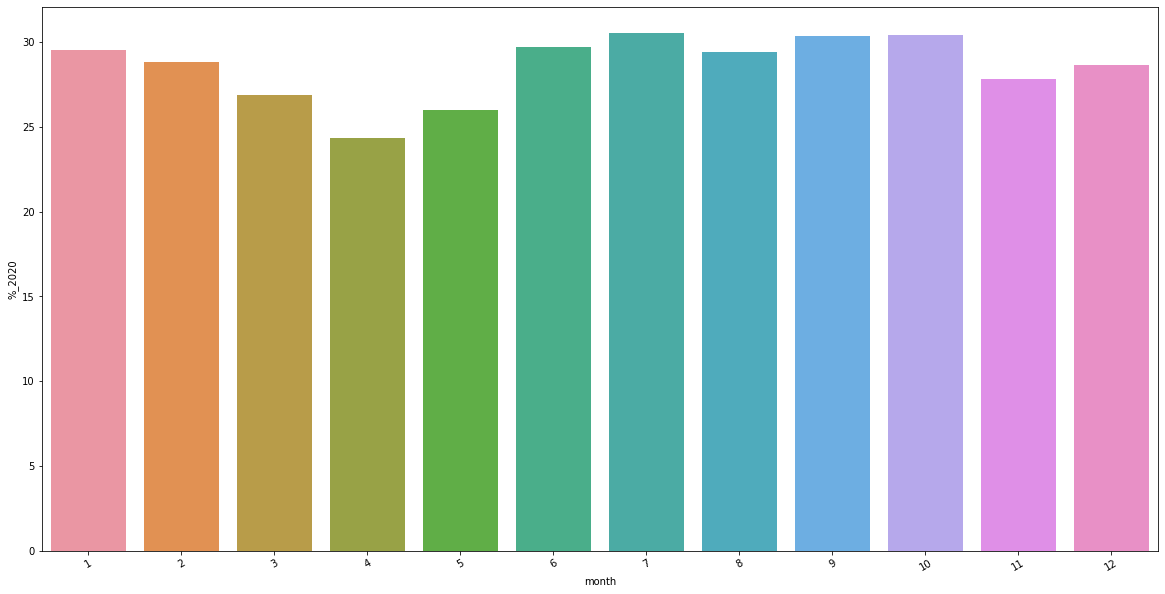

In [41]:
# График по 2020 году по %
plt.figure(figsize=(20,10))
ax = sns.barplot(data=gmv_main_months2020, x='month', y='%_2020')
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)
plt.show()

## 3.4.Соотношение долей GMV по OFF_LINE в 2021

In [ ]:
# сводная по 2021 году
gmv_main_months2021 = gmv_main_months.query('period_new > "2020-12-31"').rename(columns={'%' : '%_2021'})
gmv_main_months2021

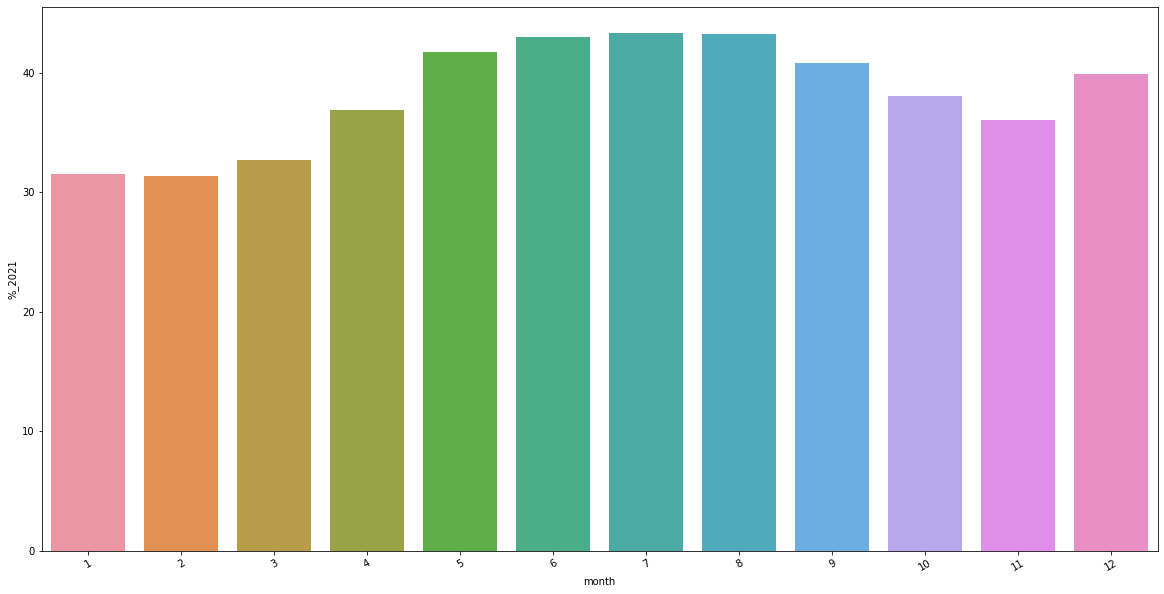

In [43]:
# График по 2021 году по %
plt.figure(figsize=(20,10))
ax = sns.barplot(data=gmv_main_months2021, x='month', y='%_2021')
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)
plt.show()

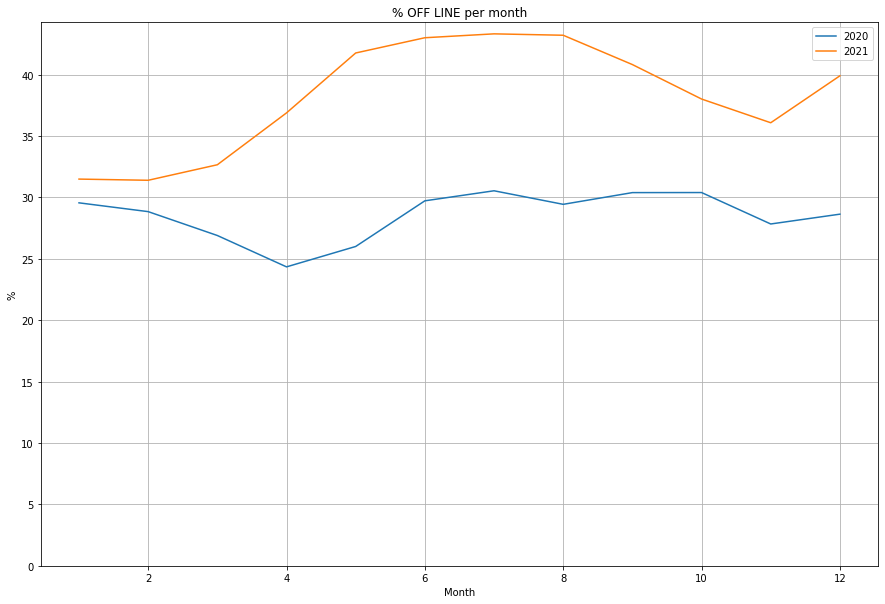

In [44]:
# Совместный график помесячно 
plt.figure(figsize=(15,10))
plt.plot(gmv_main_months2020['month'], gmv_main_months2020['%_2020'], label = '2020')
plt.plot(gmv_main_months2021['month'], gmv_main_months2021['%_2021'], label = '2021')
plt.title('% OFF LINE per month')
plt.xlabel('Month')
plt.ylabel('%')
plt.ylim(0)
plt.grid()
plt.legend()
plt.show()

## 3.5 Доля Offline GMV  от всего GMV за 2020-2021 по каналам

In [ ]:
# Сводная помесячно по каналам
channels_main_months = gmv_main.pivot_table(
index=['period_new', 'new_channel'], columns = 'new_pm', values ='gmv', aggfunc = 'sum').reset_index()

channels_main_months.columns = ['period_new', 'channel', 'off_line_gmv', 'other_gmv']

channels_main_months['%'] = channels_main_months['off_line_gmv'] / (channels_main_months['off_line_gmv'] + channels_main_months['other_gmv'])*100
channels_main_months['month'] = channels_main_months['period_new'].dt.month
channels_main_months['year'] = channels_main_months['period_new'].dt.year 


channels_main_months.head()

In [ ]:
# channels_main_months2020 по 2020 году
channels_main_months2020 = channels_main_months.query('period_new <= "2020-12-31"')
channels_main_months2020

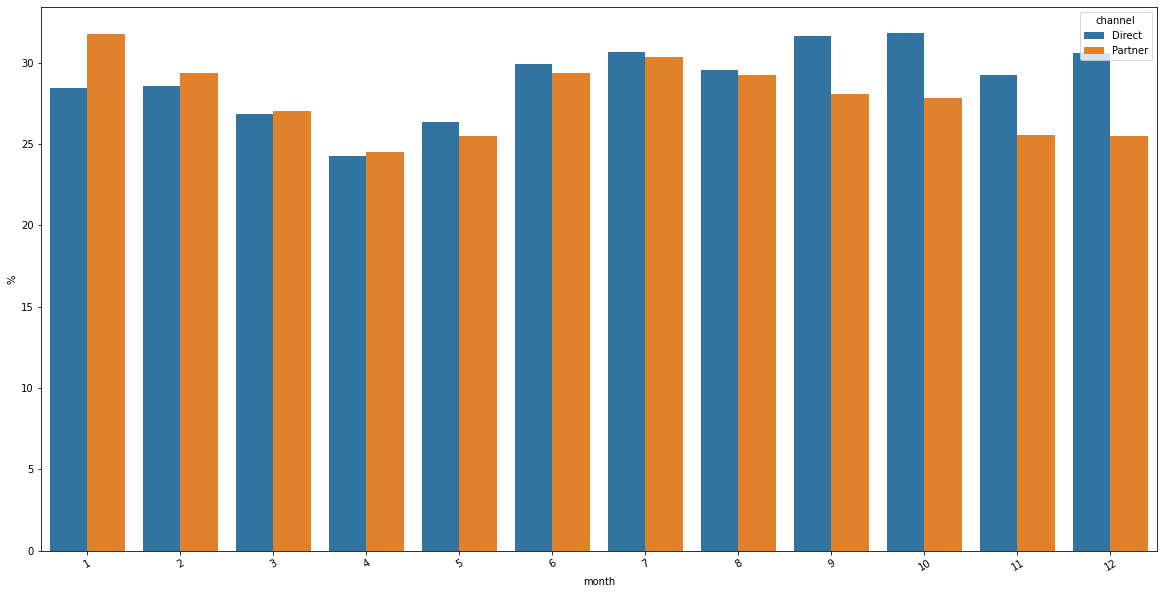

In [47]:
# График по 2020 году по %
plt.figure(figsize=(20,10))
ax = sns.barplot(data=channels_main_months2020, x='month', y='%', hue='channel')
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)
plt.show()

In [ ]:
# channels_direct_months2020 помесячно Direct 2020 год
channels_direct_months2020 = channels_main_months2020.query('channel == "Direct"').rename(columns={'%' : '%_2020'})
channels_direct_months2020

In [ ]:
# channels_main_months2021 по 2021 году
channels_main_months2021 = channels_main_months.query('period_new > "2020-12-31"')
channels_main_months2021

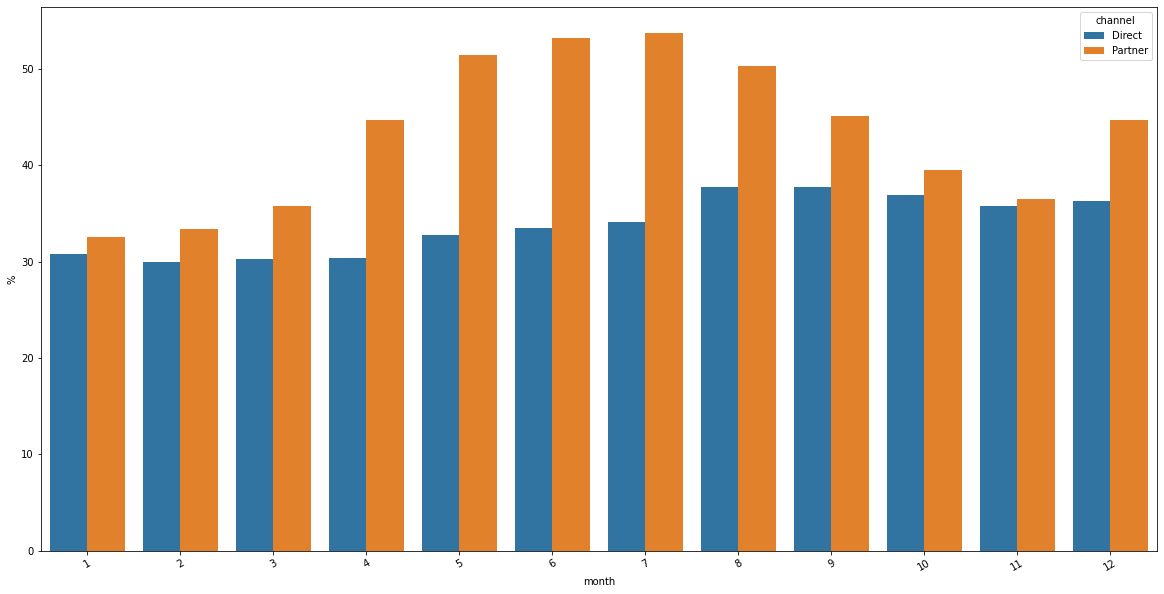

In [50]:
# График по 2021 году по %
plt.figure(figsize=(20,10))
ax = sns.barplot(data=channels_main_months2021, x='month', y='%', hue='channel')
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)
plt.show()

In [ ]:
channels_direct_months2021 = channels_main_months2021.query('channel == "Direct"').rename(columns={'%' : '%_2021'})
channels_direct_months2021

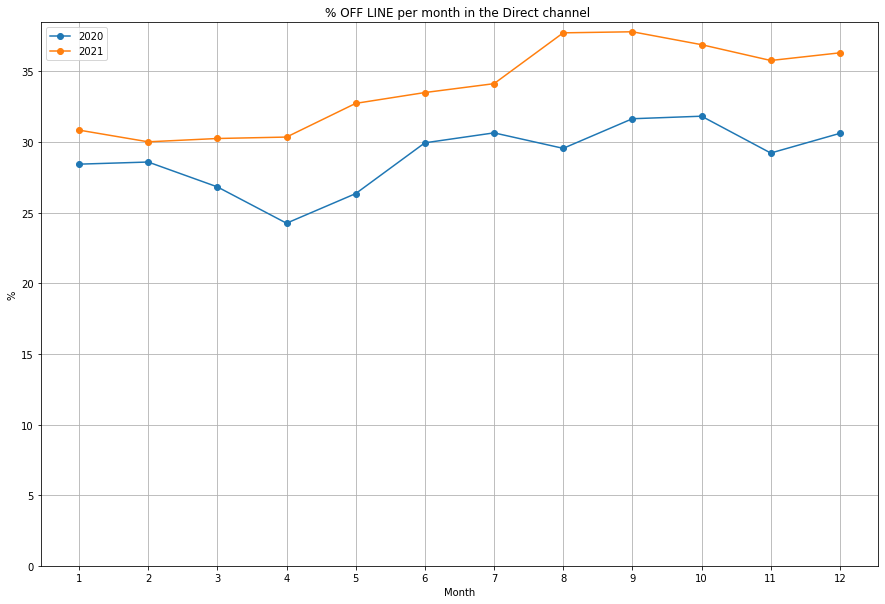

In [52]:
# График по Direct помесячно

plt.figure(figsize=(15,10))
plt.plot(channels_direct_months2020['month'], channels_direct_months2020['%_2020'], label = '2020', marker ='o')
plt.plot(channels_direct_months2021['month'], channels_direct_months2021['%_2021'], label = '2021', marker = 'o')
plt.title('% OFF LINE per month in the Direct channel ')
plt.xlabel('Month')
plt.ylabel('%')
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
plt.ylim(0)
plt.grid()
plt.legend()
plt.show()


In [ ]:
# channels_partner_months2020 по Partner 2020 год
channels_partner_months2020 = channels_main_months2020.query('channel == "Partner"').rename(columns={'%' : '%_2020'})
channels_partner_months2020

In [ ]:
# channels_partner_months2021 по каналу Partner в 2021 году
channels_partner_months2021 = channels_main_months2021.query('channel == "Partner"').rename(columns={'%' : '%_2021'})
channels_partner_months2021

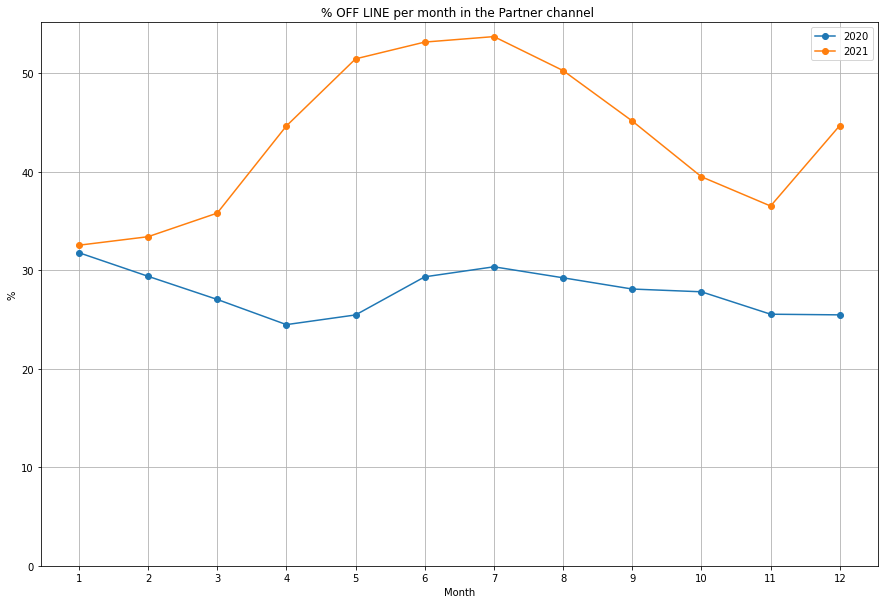

In [55]:
# График по Partner помесячно за 2 года

plt.figure(figsize=(15,10))
plt.plot(channels_partner_months2020['month'], channels_partner_months2020['%_2020'], label = '2020', marker ='o')
plt.plot(channels_partner_months2021['month'], channels_partner_months2021['%_2021'], label = '2021', marker ='o')
plt.title('% OFF LINE per month in the Partner channel ')
plt.xlabel('Month')
plt.ylabel('%')
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
plt.ylim(0)
plt.grid()
plt.legend()
plt.show()

In [ ]:
# Сводная по годам и каналам
channels_main_2020_2021 = gmv_main.pivot_table(
index=['year', 'new_channel'], columns = 'new_pm', values ='gmv', aggfunc = 'sum').reset_index()

channels_main_2020_2021.columns = ['year', 'channel','off_line_gmv', 'other_gmv']

channels_main_2020_2021['%'] = channels_main_2020_2021['off_line_gmv'] / (channels_main_2020_2021['off_line_gmv'] + channels_main_2020_2021['other_gmv'])*100

channels_main_2020_2021

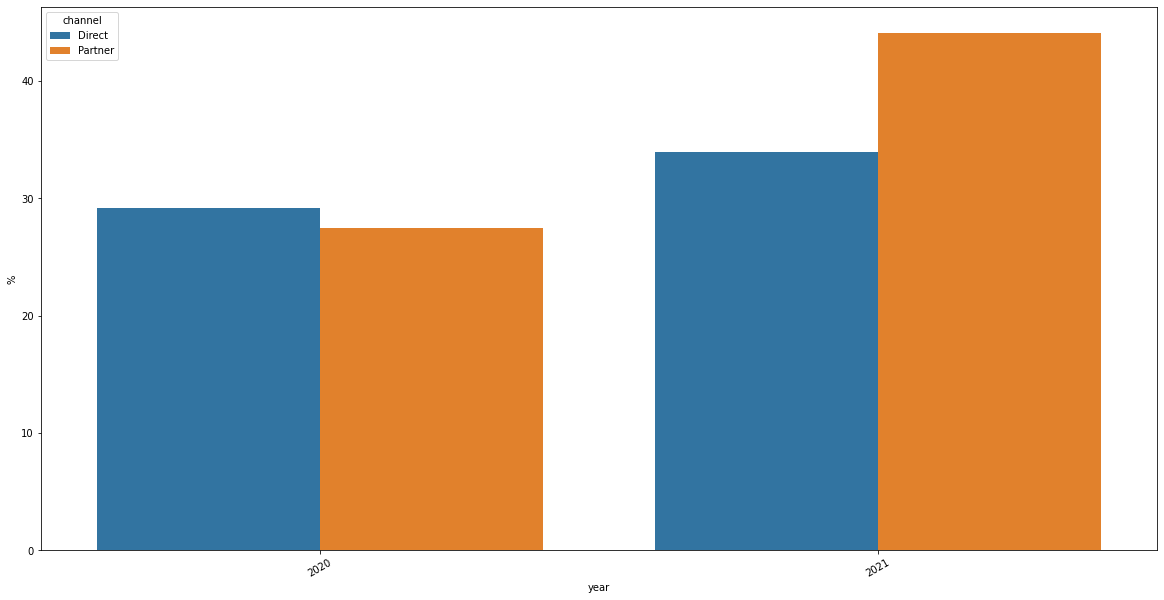

In [57]:
# График сравнения годов в разрезе channel %
plt.figure(figsize=(20,10))
ax = sns.barplot(data=channels_main_2020_2021, x='year', y='%', hue='channel')
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)
plt.show()

# Часть 4.Дополнительный анализ

In [58]:
direct_gmv_main = gmv_main.query('channel_type == "Direct"')

direct_gmv_main.shape

(1727007, 17)

In [59]:
# Функция для доп анализа
def special(df, year, x1):
    df1 = df.query('year == @year').pivot_table(index=x1, \
                  columns='new_pm', \
                  values=['gmv', 'n_orders'], 
                  aggfunc={'gmv' : 'sum', 
              'n_orders' : 'sum'}).reset_index().fillna(0)

    df1.columns = [x1, 'off_line_gmv', 'other_gmv', \
               'n_orders_offline', 'n_orders_other_pm']

    df1['AoV_offline'] = df1['off_line_gmv'] / df1['n_orders_offline']
    df1['AoV_other'] = df1['other_gmv'] / df1['n_orders_other_pm']
    
    df2 = df.query('year == @year').pivot_table(index= x1, \
                      values='store_id', aggfunc='nunique').reset_index()
    df2.columns = [x1, 'n_stores']
    #print(df2)
    df3 = df1.merge(df2, how='inner', on=x1)
    
    df3['Av_gmv_store_general'] = (df3['off_line_gmv'] + df3['other_gmv'])/ df3['n_stores']
    df3[f'%_offline_{year}'] = (df3['off_line_gmv'] / (df3['off_line_gmv'] + df3['other_gmv']) *100)
                         
    return(df3)

## 1.Verticals


In [6]:
# Сводная по годам и вертикалям
verticals_main = direct_gmv_main.pivot_table(
index =['year', 'vertical'], columns = 'new_pm', values ='gmv', aggfunc = 'sum').reset_index()

verticals_main.columns = ['year', 'vertical','off_line_gmv', 'other_gmv']

verticals_main['%'] = verticals_main['off_line_gmv'] / (verticals_main['off_line_gmv'] + verticals_main['other_gmv'])*100

verticals_main.head()

In [ ]:
# по вертикалям в 2020 году
verticals_main2020 = verticals_main.query('year == 2020') \
.rename(columns= {'%' : '%_2020', 'off_line_gmv' : 'off_line_gmv_2020', 'other_gmv' : 'other_gmv_2020'}) \
.sort_values(by='%_2020', ascending=False)

verticals_main2020_top10 = verticals_main2020.head(10)
verticals_main2020_top10

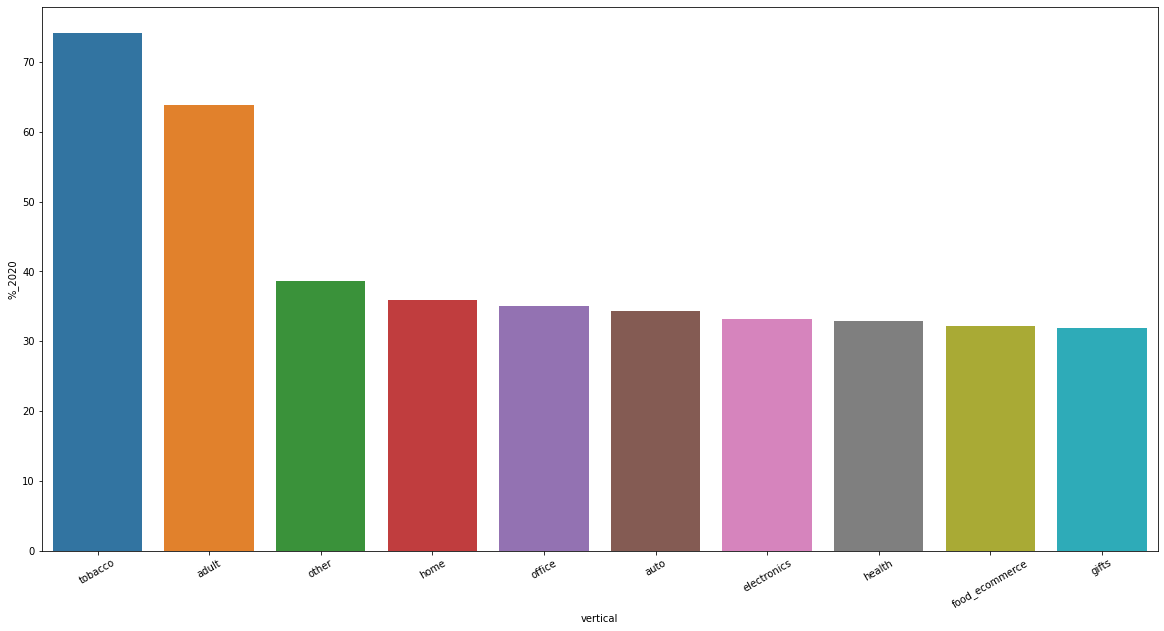

In [62]:
# График по 10 top verticals in 2020 на direct
plt.figure(figsize=(20,10))
ax = sns.barplot(data=verticals_main2020_top10, x='vertical', y='%_2020')
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)
plt.show()

In [ ]:
# по вертикалям в 2021 году
verticals_main2021 = verticals_main.query('year == 2021') \
.rename(columns= {'%' : '%_2021', 'off_line_gmv' : 'off_line_gmv_2021', 'other_gmv' : 'other_gmv_2021'}) \
.sort_values(by='%_2021', ascending=False)

verticals_main2021_top10 = verticals_main2021.head(10)

verticals_main2021_top10

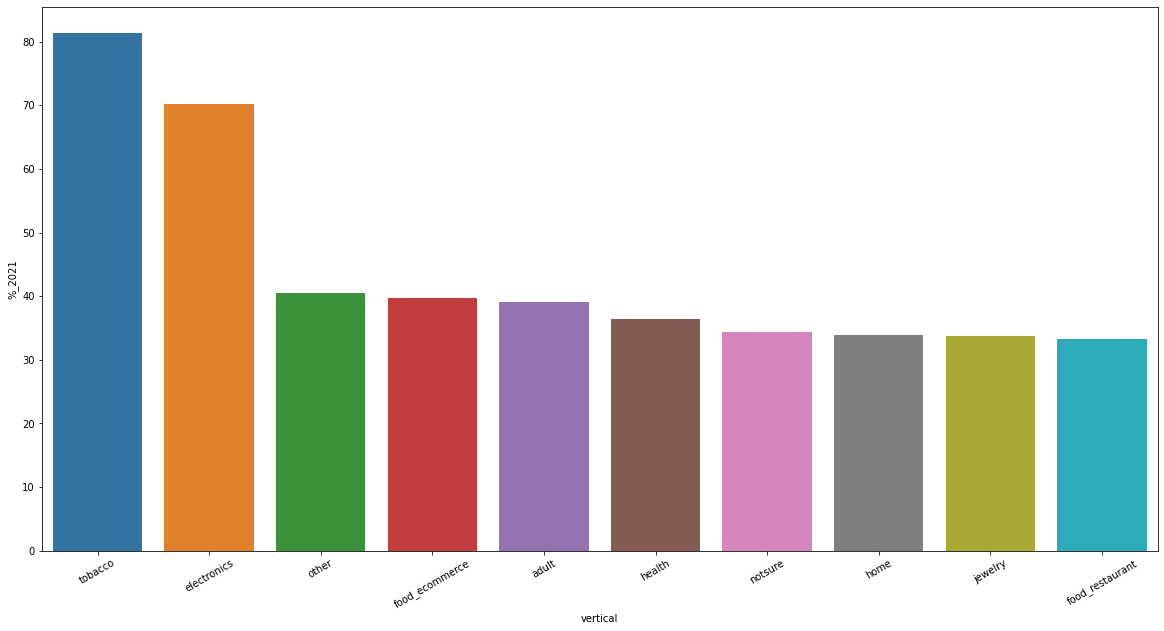

In [64]:
# График по 10 top verticals in 2021 direct channel 
plt.figure(figsize=(20,10))
ax = sns.barplot(data=verticals_main2021_top10, x='vertical', y='%_2021')
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)
plt.show()

In [65]:
verticals_2020_2021 = verticals_main2021.merge(verticals_main2020, how='left', on='vertical').fillna(0)

In [ ]:
# Статистика по вертикалям за годы 2020-2021
verticals_2020_2021 = verticals_2020_2021[['vertical', \
                             'off_line_gmv_2020', 'off_line_gmv_2021', \
                             'other_gmv_2020', 'other_gmv_2021', \
                            '%_2020', '%_2021']]
verticals_2020_2021

In [ ]:
# Доп таблица по вертикалям в 2020
vertical_extra_2020 = special(direct_gmv_main, 2020, 'vertical')
vertical_extra_2020.head()

In [ ]:
# доп таблица по вертикалям в 2021
vertical_extra_2021 = special(direct_gmv_main, 2021, 'vertical')
vertical_extra_2021.head()

## 2.Plans

In [ ]:
# Сводная по годам и странам
plan_main = direct_gmv_main.pivot_table(
index =['year', 'new_plan'], columns = 'new_pm', values ='gmv', aggfunc = 'sum').reset_index()

plan_main.columns = ['year', 'plan','off_line_gmv', 'other_gmv']

plan_main['%'] = plan_main['off_line_gmv'] / (plan_main['off_line_gmv'] + plan_main['other_gmv'])*100

plan_main

In [ ]:
# по планам и 2020 году
plan_main2020 = plan_main.query('year == 2020') \
.rename(columns= {'%' : '%_2020','off_line_gmv': 'off_line_gmv_2020', 'other_gmv' : 'other_gmv_2020'}) \
.sort_values(by='%_2020', ascending=False)

plan_main2020.head(30)

In [ ]:
# по планам и 2021 году
plan_main2021 = plan_main.query('year == 2021') \
.rename(columns= {'%' : '%_2021', 'off_line_gmv': 'off_line_gmv_2021', 'other_gmv' : 'other_gmv_2021'}) \
.sort_values(by='%_2021', ascending=False)


plan_main2021.head(30)

In [ ]:
# Сводная таблица по основным планам за 2020-2021
plan_2020_2021 = plan_main2021.merge(plan_main2020, how='inner', on='plan')


plan_2020_2021 = plan_2020_2021[['plan', 'off_line_gmv_2020', 'off_line_gmv_2021', \
'other_gmv_2020', 'other_gmv_2021', '%_2020', '%_2021']]

plan_2020_2021

## 3.Countries

In [7]:
# Сводная по годам и странам
country_main = direct_gmv_main.pivot_table(
index=['year', 'country'], columns = 'new_pm', values ='gmv', aggfunc = 'sum').reset_index()

country_main.columns = ['year', 'country','off_line_gmv', 'other_gmv']

country_main['%'] = country_main['off_line_gmv'] / (country_main['off_line_gmv'] + country_main['other_gmv'])*100

country_main.head()

In [ ]:
# по странам и 2020 году
country_main2020 = country_main.query('year == 2020') \
.rename(columns= {'%' : '%_2020', 'off_line_gmv' : 'off_line_gmv_2020', 'other_gmv' : 'other_gmv_2020'}) \
.sort_values(by='%_2020', ascending=False)

country_main2020.head(20)

In [ ]:
# сортировка по Gmv 2020
country_main2020.sort_values(by='off_line_gmv_2020', ascending=False).head(20)

In [ ]:
# по странам и 2021 году
country_main2021 = country_main.query('year == 2021') \
.rename(columns= {'%' : '%_2021', 'off_line_gmv' : 'off_line_gmv_2021', 'other_gmv' : 'other_gmv_2021'}) \
.sort_values(by='%_2021', ascending=False)

country_main2021.head(20)

In [ ]:
# сортировка по Gmv 2021

country_main2021.sort_values(by='off_line_gmv_2021', ascending=False).head(20)

In [ ]:
# Общая таблица за 2 года по странам
country_2020_2021 = country_main2021.merge(country_main2020, how='left', on='country').fillna(0)

country_2020_2021 = country_2020_2021.drop(columns=['year_x', 'year_y'])

country_2020_2021 = country_2020_2021[['country', 'off_line_gmv_2020', 'off_line_gmv_2021', \
                                  'other_gmv_2020', 'other_gmv_2021', '%_2020', '%_2021']]

country_2020_2021.head(10)

In [ ]:
# Доп таблица по странам с использованием функции special
country_extra_2020 = special(direct_gmv_main, 2020, 'country')
country_extra_2020.head()

In [ ]:
country_extra_2021 = special(direct_gmv_main, 2021, 'country')
country_extra_2021.head()

## 4.Other payments in another period (п.4 декабрь OFF_Line)

In [98]:
december_direct_main_2021 = direct_gmv_main.query('period_new == "2021-12-01"')

december_direct_main_2021['new_pm'].value_counts(normalize=True)

other      0.75
OFF LINE   0.25
Name: new_pm, dtype: float64

In [ ]:
december_direct_main_2021.head()

In [ ]:
december_2021_gmv_pivot = december_direct_main_2021.pivot_table(
    index = 'store_id', columns= 'new_pm', values='gmv', aggfunc = 'sum') \
.reset_index().fillna(0)

december_2021_gmv_pivot.columns = ['store_id', 'off_line_gmv', 'other_gmv']

december_2021_gmv_pivot.head()

In [101]:
december_direct_main_2021['new_pm'].value_counts()

other       63155
OFF LINE    21195
Name: new_pm, dtype: int64

In [102]:
december_2021_gmv_pivot['pm'] = 0

december_2021_gmv_pivot.loc[(december_2021_gmv_pivot['other_gmv'] <= 0.00) & \
                            (december_2021_gmv_pivot['off_line_gmv'] > 0.00) , 'pm'] = 'Only OFF LINE'
december_2021_gmv_pivot.loc[(december_2021_gmv_pivot['other_gmv'] > 0.00) & \
                            (december_2021_gmv_pivot['off_line_gmv'] <= 0.00) , 'pm'] = 'Only other payments'
december_2021_gmv_pivot.loc[(december_2021_gmv_pivot['other_gmv'] > 0.00) & \
                            (december_2021_gmv_pivot['off_line_gmv'] > 0.00) , 'pm'] = 'Mixed payments'
december_2021_gmv_pivot.loc[(december_2021_gmv_pivot['other_gmv'] <= 0.00) & \
                            (december_2021_gmv_pivot['off_line_gmv'] <= 0.00) , 'pm'] = 'no data'

december_2021_gmv_pivot['pm'].value_counts()

Only other payments    21106
Only OFF LINE           6088
Mixed payments          5504
no data                    1
Name: pm, dtype: int64

In [ ]:
stores = december_2021_gmv_pivot.query('pm == "Only OFF LINE"')['store_id']

december_2021_off_line = december_2021_gmv_pivot.query('store_id in @stores').sort_values(by='off_line_gmv', ascending= False)

december_2021_off_line.head()

In [ ]:
gmv_pm_main_2020_2021 = gmv_main[['period_new', 'store_id', 'payment_method', 'gmv', 'new_pm', \
                                  'new_channel', 'n_orders']].copy()

gmv_pm_main_2020_2021.head()

In [ ]:
# Таблица по списку store_id из декабря 2021
gmv_pm_main_offline_stores_2020_2021 = gmv_pm_main_2020_2021.query('store_id in @stores')
gmv_pm_main_offline_stores_2020_2021.head()

In [106]:
gmv_pm_main_offline_stores_2020_2021['new_pm'].value_counts()

OFF LINE    108548
other        17099
Name: new_pm, dtype: int64

In [ ]:
# Список всех магазинов, имеющих other payments в другие периоды без учета каналов
stores2 = gmv_pm_main_offline_stores_2020_2021.query('new_pm == "other"')['store_id']
stores2.unique()

In [ ]:
# off_line Магазины из списка декабря 2021 и по Direct
gmv_pm_main_direct_stores_2021 = gmv_pm_main_2020_2021.query('store_id in @stores & new_channel == "Direct"')
gmv_pm_main_direct_stores_2021.head()

In [109]:
# По Direct
gmv_pm_main_direct_stores_2021['new_pm'].value_counts()

OFF LINE    108028
other        17002
Name: new_pm, dtype: int64

In [ ]:
# Список всех магазинов, имеющих other payments в другие периоды по Direct
stores3 = gmv_pm_main_offline_stores_2020_2021.query('new_pm == "other" & new_channel == "Direct"')['store_id'].unique()
stores3

In [ ]:
# Новая таблица 
gmv_pm_main_direct_other_2021 = gmv_pm_main_2020_2021.query('store_id in @stores3 & new_channel == "Direct"')

gmv_pm_main_direct_other_2021 = gmv_pm_main_direct_other_2021[['period_new', 'store_id', 'gmv', 'new_pm', 'n_orders']]

gmv_pm_main_direct_other_2021.head()

In [ ]:
# Делаю сводную
stores_other_pm_pivot = gmv_pm_main_direct_other_2021.pivot_table(
    index=['store_id', 'new_pm'], 
    columns='period_new', 
    values=['gmv', 'n_orders'], aggfunc = 'sum').reset_index().fillna(0)

stores_other_pm_pivot.columns = ['store_id', 'payment_method', \
              'n_orders_Jan2020', \
              'n_orders_Feb2020', \
              'n_orders_March2020', \
              'n_orders_Apr2020', \
             'n_orders_May2020', \
             'n_orders_June2020', \
             'n_orders_July2020', \
             'n_orders_Aug2020', \
             'n_orders_Sep2020', \
             'n_orders_Oct2020', \
             'n_orders_Nov2020', \
             'n_orders_Dec2020', \
              'n_orders_Jan2021', \
              'n_orders_Feb2021', \
              'n_orders_March2021', \
              'n_orders_Apr2021', \
             'n_orders_May2021', \
             'n_orders_June2021', \
             'n_orders_July2021', \
             'n_orders_Aug2021', \
             'n_orders_Sep2021', \
             'n_orders_Oct2021', \
             'n_orders_Nov2021', \
             'n_orders_Dec2021', \
             'gmv_Jan2020', \
             'gmv_Feb2020', \
             'gmv_March2020', \
             'gmv_Apr2020', \
             'gmv_May2020', \
             'gmv_June2020', \
             'gmv_July2020', \
             'gmv_Aug2020', \
             'gmv_Sep2020', \
             'gmv_Oct2020', \
             'gmv_Nov2020', \
             'gmv_Dec2020', \
             'gmv_Jan2021', \
             'gmv_Feb2021', \
             'gmv_March2021', \
             'gmv_Apr2021', \
             'gmv_May2021', \
             'gmv_June2021', \
             'gmv_July2021', \
             'gmv_Aug2021', \
             'gmv_Sep2021', \
             'gmv_Oct2021', \
             'gmv_Nov2021', \
             'gmv_Dec2021']

stores_other_pm_pivot.head()

## 5.Carrier

In [ ]:
direct_gmv_main['carrier'] = direct_gmv_main['carrier'] \
.str.replace(r'^custom.*$', r'Custom', case=False) \
.str.replace(r'^Boxberry.*$', r'Boxberry', case=False) \
.str.replace(r'^Яндекс.*$', r'Яндекс', case=False) \
.str.replace('U.S.P.S.', 'USPS') \
.str.replace('Способы доставки от Почты России', 'Почта России') \
.str.replace('Russian Post' , 'Почта России') \
.str.replace(r'^.*(?i)\bЯндекс\b.*$', r'Яндекс') \
.str.replace(r'^.*(?i)\bpickpoint\b.*$', r'Pickpoint') \
.str.replace(r'^.*(?i)\bСДЭК\b.*$', r'СДЭК') \
#.str.replace(r'^.*\bЯндекс\b.*$', r'Яндекс', case=False)

In [ ]:
direct_gmv_main['carrier'].unique()

In [ ]:
new_carrier_list = ['<Pickup>', 'UNKNOWN']
new_column(direct_gmv_main, 'new_carrier', 'carrier', new_carrier_list)

In [ ]:
# Сводная по годам, carrier 
carrier_main_2020_2021 = direct_gmv_main.pivot_table(
index=['year', 'new_carrier'], columns = 'new_pm', values ='gmv', aggfunc = 'sum').reset_index().fillna(0)

carrier_main_2020_2021.columns = ['year', 'carrier', 'off_line_gmv', 'other_gmv']

carrier_main_2020_2021['%'] = carrier_main_2020_2021['off_line_gmv'] / (carrier_main_2020_2021['off_line_gmv'] + carrier_main_2020_2021['other_gmv'])*100

carrier_main_2020_2021

In [ ]:
# по доставке  в 2020 году
carrier_main_2020 = carrier_main_2020_2021.query('year == 2020') \
.rename(columns= {'%' : '%_2020', 'off_line_gmv' : 'off_line_gmv_2020', 'other_gmv' : 'other_gmv_2020'}) \
.sort_values(by='%_2020', ascending=False)

#df_carr_meth2020_1 = carrier_main_2020.head(20)
carrier_main_2020

In [ ]:
# по доставке  в 2021 году
carrier_main_2021 = carrier_main_2020_2021.query('year == 2021') \
.rename(columns= {'%' : '%_2021', 'off_line_gmv' : 'off_line_gmv_2021', 'other_gmv' : 'other_gmv_2021'}) \
.sort_values(by='%_2021', ascending=False)

# df_carr_meth2021_1 = carrier_main_2021.head(10)
carrier_main_2021

In [ ]:
carrier_2020_2021 = carrier_main_2021.merge(carrier_main_2020, how='left', on='carrier').fillna(0)
carrier_2020_2021 = carrier_2020_2021[['carrier', \
                             'off_line_gmv_2020', 'off_line_gmv_2021', \
                             'other_gmv_2020', 'other_gmv_2021', \
                            '%_2020', '%_2021']]
carrier_2020_2021.head(20)